# Neural Networks In Python
Notes On Neural Network Training: John Guirguis & Gianluca Mucci 07/18/2025  
**Sources:** Here is a list of the sources used in the creation of this notebook:
- https://www.geeksforgeeks.org/python/libraries-in-python/
- https://pytorch.org/
- https://pybamm.org/
- https://matplotlib.org/3.5.3/index.html
- https://pypi.org/project/ipywidgets/

## Necessary Imports for Neural Networks ##
- Below are a list of neccessary imports for neural network training in Python, along with installation instructions as well.

In [1]:
'''
Use the following format if any of the libraries are not installed:
!pip install -q library_name1 library_name2....
'''

#Import all of the neccessary libraries
import pybamm
import matplotlib as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import inspect
import ipywidgets as widgets
widgets.IntSlider()
import pickle
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import torch
import torch.nn as nn
import torch.optim as optim
%matplotlib inline
print("Libraries imported successfully!")



Libraries imported successfully!


Here is a quick description of what each library does:

**pybamm:** Creates physics-based battery models in python we will compare these to our ground truth values.  
**matplotlib:** This library is used for plotting numerical data, used in data analysis. Pie charts, histograms, and many others can be plotted using this library.  
**pandas:** Essential for data scientists, contains high level data structures, cleaning, sorting, iteration, visualizations, conversion, etc.  
**numpy:** Supports large matrix calculations and multi-dimensional data. Tensorflow uses this too to support these large calculations. Array interface is key here.  
**matplotlib.pyplot:** Used for the interface, matlab way of plotting. Responsible for opening figures on your screen.  
**inspect:** Used for the examination of data in python, particularly objects and returns boolean values.  
**ipywidgets:** Responsible for jupyter interactive widgets.  
**pickle:** See the next section, this is how we store our discharging and charging profiles as serialized python objects.  
**matplotlib.cm:** Used for building colour maps, handling colours accordingly.  
**matplotlib.colors:** Converts numbers or arguments to RGB or RGBA.  
**torch:** Largest machine learning library which optimizes tensor computations, applications in neural networks as well.  
**torch.nn:** The building blocks for graphs, contain many aspects including loss functions which are essential for neural network analysis.  
**torch.optim:** Used for gradient calculations, essential for neural network analysis.

**NOTE:** The %matplotlib should be followed by "widget" instead of "notebook", but in here we are using notebook due to an error. The widget command works in VS Code.


## Storing/Viewing Data for Charging and Discharging ##
This is often done using pkl files, or "pickling".


**Pickling (.pkl files):** This saves data as serialized python objects. These store models, data-preprocessing objects, and here, datasets for each cell type.
- In general, these have python dataframes, which each hold a table with various columns and entries.
- These can be easily be accessed like a file, we will have to use 'rb' for the operator since these are not stored in a word-like fashion.  
- Here is how you would unpack a pkl file, shown in the cell below deserializing the data.
- We will define this as a function, called unpack_pickle().


In [2]:
def unpack_pickle(file_path):
    #Extract the data using the 'rb' moderator and the pickle library we imported before.
    with open(file_path, 'rb') as file:
        dataframe_list = pickle.load(file)          
    #Return the data loaded from the pkl file.
    return dataframe_list

- In this case, we store the charging and discharging data, which are ground-truth temporal data sets for voltage, temperature and current.
- A general case for python is to double up the slashes after getting a file path from the directory using Ctrl+Shift+C.
- These pkl files stored within W5, W10, and W8 folders each have profiles for many cycles of the indicated cell.
- To be specific, these .pkl files have a list of dataframes (tables) which represent cycles of that battery.
- In this program, we will load up one of these cycles from each file to obtain sufficient data.
- Let's view one of these .pkl files to see what it looks like:

In [3]:
#Call the function to unpack this data from tke .pkl file. "df" stands for data frame, which we will manipulate.
W5_Ch_1_dfs = unpack_pickle(file_path = "C:\\Users\\Laptop\\Desktop\\Neural Network Notes\\NN_SPMe\\NN_SPMe\\W5\\Charging.pkl")
W5_Ch_1_dfs

[       Step_Index  Test_Time(s)  Current(A)  Voltage(V)  Charge_Capacity(Ah)  \
 0               7      0.000000    2.031097    3.475510             0.000042   
 1               7      0.100000    2.268494    3.477119             0.000107   
 2               7      0.200200    2.314087    3.478035             0.000171   
 3               7      0.300400    2.327332    3.479191             0.000236   
 4               7      0.399800    2.338623    3.480155             0.000301   
 ...           ...           ...         ...         ...                  ...   
 88908          11  17401.271756    0.000000    4.196227             4.109324   
 88909          11  17402.271256    0.000000    4.196182             4.109324   
 88910          11  17403.271556    0.000000    4.196234             4.109324   
 88911          11  17404.272456    0.000000    4.196220             4.109324   
 88912          11  17404.273356    0.000000    4.196216             4.109324   
 
        Aux_Temperature(¡æ

- As you can see, we have various tables, or dataframes with various different columns all recorded during cycles of this battery.
- These allow us to control which ones we want, this will be brought up in the future when we mention cycle_index.
- Below is a description of each column, and what the recorded values represent.

**Data Point:** Represents the number of the recording, starting from zero and going to the ten thousands for each data point. These have no title.  
**Step_Index:** Represents the step/stage within the fast-charging index, could be resting, charging, etc.  
**Test_Time (s):** The time elapsed of the data.  
**Current (A):** Current running through a battery.  
**Voltage (V):** The voltage across the terminals of the battery, terminal voltage most likely.  
**Charge Capacity (Ah):** This is the quantity of charge within the battery, assuming a 0 start.   
**Temperatures (Deg C):** Temperature of the battery surface, important for safety aspects to prevent unnoticed overheating leading to flammable incidents.

**NOTE:** Some dataframes have 5 columns, not 6 since temperature is not included, these will not be counted as we need voltage, current, and temperature.  
Now, we must deal with the imports of various libraries to help us out.

## Loading Data From .pkl Files ##
 - Now, we will cover how to load the data to usable forms for our neural networks to evaluate.
 - First, we will define our columns of interest as a variable as we will see in the code cell below, in this case we will use a tuple to ensure these stay consistent:

In [4]:
#Define a tuple for the columns of interest in the .pkl files.
columns_of_interest = ("Test_Time(s)", "Current(A)", "Voltage(V)", "Aux_Temperature(¡æ)_1")

**NOTE:** It is often helpful to simply copy and paste directly from the pkl file the columns, since some may include symbols we cannot print. This is why it is essential we unpack and view the format of the profiles.  
**NOTE:** We are not concerned with charging capacity here, just those 4 since we are always dealing with Voltage, Current, and Temperature (VIT).  

**load_cell_data():** From the many dataframes (tables) we have in our .pkl file, we want to load a specific one which meets our criteria, and return only the selected columns to store in python as our dataframe for that cell.
- This function will have 3 parameters. These are briefly described below along with their variable types.

**file_path (str):** This represents the path towards the .pkl file, ensure the directory is proper.  
**cycle_index (int):** Index of the DataFrame in the list we will retrieve. This is required because the pkl file is a list of tables, we will pick often the first or second one.  
**columns_of_interest (list/tuple):** The list of column names to extract from the dataframe.

**NOTE:** The cycle index is often 1 or 2 since we want fresh data on a cell with no use, we want the first set of data for this reason.
- This will then return a new data frame, in Pandas format since this is the library we will be working with throughout this program (pandas.DataFrame).

**Iteration Through A Tuple:** Using dataframes, we can quickly create a list of columns that match, in order using one line of code which is useful for many data techniques.
- As seen in the code below, the list of available columns is broken down into three parts:

**col:** Tells python that we are within a list of columns, using the keyword "col".  
**for col in columns_of_interest:** Iterates through the columns we are interested in.
**if col in df.columns:** Only include those in the for loop that are in the dataframe.

- Then, we can set the dataframe variable equal to the same variable with the index of the available columns.

**df.rename():** Takes one argument in the format of (columns = rename_map). This rename map is a dictionary where the keys are the old column names and the values are the new names corresponding with each.  

**NOTE:** These columns can be multiplied by scalars, just like the current is below for convention within the pybamm library.
- Finally, we add a column to the dataframe. This can be done the same we append a dictionary, by setting the dataframe variable at the index of the new column name equal to something new.
- Here, this new thing is an interpolation, done using a pybamm function. But first, we need to bind time and current into a column stack since this version of pybamm.Interpolant (the function we will be using) takes only two argument. This can be done using the following function.

**np.column_stack():** This takes one positional argument (x,y), where x and y are the two values holding columns. It will return a 2D list where each one is [xn,yn], all the way down to the last value. These lists are stacked on top of each other to show that the list number is the row and the index of the lists are the columns.  
- **NOTE:** x and y will be the columns "Time" and "I" (respectively), ensure to apply a ".values" extension at the end of each to turn them into lists so the numpy library can use it properly.
- We can then use the pybamm.Interpolant() function to create a new column dependent on the other two.

**pybamm.Interpolant():** A function that creates an interpolation of a set of values, a function with respect to some variable which we will define. This version takes two arguments, in this case we will use ones that are familiar.  
- The first argument involves the column stack which we previously created.
- The second argument is a special one, which is listed below.  
**pybamm.t:** Since pybamm is specifically designed for these battery simulations, having this function as the second argument will tell pybamm that our other argument represents columns of a time vs current relationship.
- This will then create a new column in a dataframe, which each entry saying "interpolation function" based off the relationship we created.

After all of this is done, we return this dataframe back to the main function.

In [5]:
def load_cell_data(file_path, cycle_index, columns_of_interest):
    """Loads a specific dataframe from the .pkl file, returning selected columns from
    it and renaming them. For paramters and returns, see the text above."""

    #Call our previous function called unpack_pickle() to obtain our dataframe list.
    df_list = unpack_pickle(file_path)

    #Now, it is important that we verify our cycle_index is in range. This ensures the number is not too large, negative, or 0.
    if cycle_index > len(df_list) or cycle_index <= 0:
        raise IndexError("The index is not valid for this dataset.")

    #Load up the dataframe, ensuring the index is put into python terms since the first one is 0 index.
    df = df_list[cycle_index - 1]

    #Create a list of all col values from columns_of_interest, but only include those where col is also a column in the DataFrame.
    available_columns = [col for col in columns_of_interest if col in df.columns]
    df = df[available_columns]

    #Create the new names of the columns as a dictionary to match the previous ones to the future ones.
    rename_map = {"Test_Time(s)":"Time", "Current(A)":"I", "Voltage(V)":"V", "Aux_Temperature(¡æ)_1":"T"}
    df = df.rename(columns = rename_map)

    #Reverse the current direction for convention and various needs within the files and calculation.
    df["I"] = -df["I"]

    #Define our x and y columns for our interpolation data, then combine them into a column stack.
    x = df["Time"].values
    y = df["I"].values

    #Create a column with a interpolation of I(t) in the same dataframe for later use.
    df["Interp_I"] = pybamm.Interpolant(x,y, pybamm.t)

    #Return this newly made dataframe back to the main program.
    return df
    

After this stage, all that is left to do is to load in these files using the dataframe lists we have stored in pkl files. To do this, we simply call our function 6 times with each of the file paths that we have.  
**NOTE:** The cycle indices can be played with, here they are all set to 2 but can be modified if we want aged datasets, or potentially random datasets if we would like to experiment.

In [6]:
#Calling our load_cell_data function with all of our appropriate filepaths, obtaining a dataframe for each one.
W10_Ch_1 = load_cell_data(file_path = "C:\\Users\\Laptop\\Desktop\\Neural Network Notes\\NN_SPMe\\NN_SPMe\\W10\\Charging.pkl", cycle_index = 2, columns_of_interest = columns_of_interest)
W10_Dch_1 = load_cell_data(file_path = "C:\\Users\\Laptop\\Desktop\\Neural Network Notes\\NN_SPMe\\NN_SPMe\\W10\\Discharging.pkl", cycle_index = 2, columns_of_interest = columns_of_interest)

W5_Ch_1 = load_cell_data(file_path = "C:\\Users\\Laptop\\Desktop\\Neural Network Notes\\NN_SPMe\\NN_SPMe\\W5\\Charging.pkl", cycle_index = 2, columns_of_interest = columns_of_interest)
W5_Dch_1 = load_cell_data(file_path = "C:\\Users\\Laptop\\Desktop\\Neural Network Notes\\NN_SPMe\\NN_SPMe\\W5\\Discharging.pkl", cycle_index = 2, columns_of_interest = columns_of_interest)

W8_Ch_1 = load_cell_data(file_path = "C:\\Users\\Laptop\\Desktop\\Neural Network Notes\\NN_SPMe\\NN_SPMe\\W8\\Charging.pkl", cycle_index = 2, columns_of_interest = columns_of_interest)
W8_Dch_1 = load_cell_data(file_path = "C:\\Users\\Laptop\\Desktop\\Neural Network Notes\\NN_SPMe\\NN_SPMe\\W8\\Discharging.pkl", cycle_index = 2, columns_of_interest = columns_of_interest)

Now that we have loaded all of the data from the files, lets view an example of a dataframe to take note of the aspects we just mentioned.

In [7]:
#Let's view a sample dataframe here:
W5_Ch_1

,Time,I,V,T,Interp_I
0,0.000000,-2.036865,3.472629,23.284555,ing_functio(time)
1,0.100200,-2.276794,3.473945,23.284555,ing_functio(time)
2,0.200400,-2.309814,3.475214,23.284555,ing_functio(time)
3,0.300700,-2.318146,3.475947,23.284555,ing_functio(time)
4,0.399800,-2.328369,3.477003,23.284555,ing_functio(time)
...,...,...,...,...,...
88707,17446.888708,-0.000000,4.196408,23.008286,ing_functio(time)
88708,17447.889508,-0.000000,4.196390,23.008287,ing_functio(time)
88709,17448.889008,-0.000000,4.196340,23.008287,ing_functio(time)
88710,17449.888808,-0.000000,4.196278,23.027857,ing_functio(time)


As you can see, this has our columns of interest all nicely formatted with our new interpolated function as well. It has the proper length and all the information we need for the program. We can now have our ground-truth values for everything, now we will utilize our pybamm library to create expected values based off the physics of the cell and these inputs.

# Utilizing PyBAMM -> Simulations & Physics-Based Expected Values #  
- As stated before, we will now pass this dataframe to a function we will define that utilizes PyBAMM to run simulations and create expected values based off the physics of the cell.
- This is the second step of the process, after this we will use a neural network to correct these projected values and make our physics-based models even more accurate then before.
- First, lets define our function which we will be using in this stage of the program.

**SPMe_Sim():** This is the function we will use to run our simulations, only requiring two arguments which are listed below. The return will be the same dataframe but with new columns for voltage and temperature RMSE, error, and SPMe values.

**cell_data (.pandas dataframe)**: This is the dataframe we are using, we will pass the charging/discharging profiles we would like tested into this function.  
**charging (int/boolean):** This will be either one or zero, serving as a boolean activator in our program set to 1 if we are passing a charging profile, 0 if we are passing a discharging profile.

- Now, we must select our model type, parameter set, and then update that parameter set with the intial values from our dataframe. This is done using the following 3 functions:

**pybamm.lithium.ion.SPMe():** The usage of this function specifies that we are using a lithum-ion battery for our simulation, it also takes one dictionary argument.  
- There are options for further specifics, including cell geometry, thermal aspects, contact resistance, and more which can be viewed here: https://docs.pybamm.org/en/stable/source/examples/notebooks/models/thermal-models.html
- In general, SPMe indicates this is a Single Particle Model with an Electrolyte. This is our BaseModel in this case, and our thermal model will be lumped meaning our argument is the dictionary {"thermal": "lumped"}.
- All of these thermal models solve different PDEs, ODEs, and other equations for temperature.


**pybamm.ParameterValues():**  This defines the set of required values we will need for our simulation. In this case, the argument is the parameter set you are using and in this case it is the "ORegan2022" model for LG M50 cells as a string.  
**param_set.update():** This will allow us to pass our initial values in the form of a dictionary. All of these parameters (keys) with their values (values) are listed in the table below, these are listed in proper format with the cell data as well.

|Parameter (Key)|Dataframe Value|
|---------------|---------------|
|"Current Function [A]"|cell_data["Interp_I"].values[0]|
|"Ambient temperature [K]"|cell_data["T"].values[0] + 273|
|"Initial temperature [K]"|cell_data["T"].values[0] + 273|
|"Reference temperature [K]"|cell_data["T"].values[0] + 273|
|"Total heat transfer coefficient [W.m-2.K-1]"|Material Dependent|
|"Maximum concentration in negative electrode [mol.m-3]"|Battery Specific|
|Open-circuit voltage at 100% SOC [V]"|Measured Value, Battery Specific|
|"Upper voltage cut-off [V]"|Measured Value, Battery Specific|
|"Lower voltage cut-off [V]"|Measured Value, Battery Specific|

- As you can see, some of these values are from our cell-data, but some are measured values dependent on which battery we are using. These are specifics we can find in the cell documentation most likely.
- After this, we will then use an if condition to update our parameter set with a conditional based on our charging variable. We can say "if charging:" and then update the parameter set with the same function and the following argument.

|Parameter (Key)|Dataframe Value|
|---------------|---------------|
|"Initial concentration in negative electrode [mol.m-3]"|Measured Value|
|"Initial concentration in positive electrode [mol.m-3]"|Measured Value|

- Intuitively, when we are charging these become important as the quantity of charge present at the start can affect the current measurements. During discharging, this is not needed.
- Now we will deal with spatial variables, which will give the simulation context toward the the size of things in the cell using a pybamm definition.

**standard_spatial_vars:** Defines the standard set of spatial variables in pybamm simulations, allowing this single particle object here to have some context while it moves in simulation. This process is known as spacial discretization.
- Now to create points, we will take the domains of various aspects and scale them accordingly.
- This is similar to meshing in MATLAB, we will first work with our electrodes and separation, then work with the radial domains of particles too. In general, 'n' stands for negative (anode), 's' stands for sepration, and 'p' stands for positive.
- x is representative of the distance, and r is representative of radial direction inside particles.
- For resolution, think like this is how many pixels there are along each axis.
- Another important part is the statements param.L or param.prim.R.typ, how we write the symbols which are shown in the table below.

|var.()|Domain|Scaling Factor & Distance/Point(Resolution)|Symbol|
|------|------|-------------------------------------------|------|
|x_n|Negative Cathode|10^-6 (1 Micrometer)|L (m)|
|x_s|Separation|10^-6 (1 Micrometer)|L (m)|
|x_p|Postive Cathode|10^-6 (1 Micrometer)|L (m)|
|r_n|Radius of Negative Cathode|10^-7 (100 Nanometers)|R (m)|
|r_p|Radius of Positive Cathode|10^-7 (100 Nanometers)|R (m)|

- As seen below, we also need to cast the amount of points here in integers, this can be done by typecasting. 
- The general format for each point for each var.() is shown below, this is the format for all of the entries of the dictionary we will call var_pts in the program below.

**var.domain: int((param_set.evaluate(model_spme.param.(n, s, or p).(L or prim.R_typ)/1e-(6 or 7)))**

- Now, we can run the simulation using the following function from pybamm.

**pybamm.Simulation():** This function will run the simulation for us, taking three arguments which are included below and set equal to a variable we will call sim.

**model_spme:** The variable we stored our model information in earlier.
**parameter_values = param_set:** On the right hand of the equals sign is the dictionary holding our intial values, updated accordingly.
**var_pts = var_pts:** On the right hand of the equals sign, we send our dictionary of domain points.

- Using the variable from before, we then need to actually run our simulation, and we can so this using another function which we can attach onto our sim variable:

**.solve():** Takes a column of time values as a list (apply .values), and runs the simulation with respect to this variable throughout. The argument can be a list consisting of a start time or end time, or a longer list and it will take start and end automatically.

- We then set this equal to another variable, here we will call this solution_SPMe which is an object within th pybamm solver we are using.
- After this, we simply need to extract the things we will be using for further purposes in the program from this object in pybamm.
- We will be extracting two things. The terminal voltage and the x-averaged cell temperature.

**Terminal Voltage:** The voltage across two terminals of a battery while connected to a load.
**X-Averaged Temperature:** Using our mapping/meshing from before, this is the average temperature across our x dimension.
- To extract, we use the following syntax to create new columns within our dataframes:

**cell_data["(V or T)_SPMe"] = solution_SPME["(Terminal Voltage [V] or X-averaged cell temperature [K])"].entries**

- In our model, these will be the simulated values we will correct using a neural network.  
- We will now create two new columns, one for the voltage error and one for the temperature error. This can simply be done by subtracting the cell_data column from the new, SPMe column for each variable.  
**NOTE:** Similar to how matrices work in linear algebra, subtracting two columns involve subtracting each of the entries one-by-one. This is the same for squares, squareroots, and multiplying by scalars, it is entry-based.
- Now, the final step is to create two other columns for the Root Mean Squared Error.

**Root Mean Squared Error (RMSE):** We take the error, square it, sum the other errors and divide by the number of entries. This gives us the mean squared error, RMSE is obtained by taking the square root of this. 

$RMSE = \sqrt[]{\frac{1}{N}\sum_{i=1}^N(x_{i} - \bar x_{i})^2}$ -> Where $x$ represents the ground truth values, $\bar x$ are the simulation values, and $N$ is the number of entries.
- Numpy allows us to use the np.mean() function to calculate this mean for us, summing down the column and dividing by the number of entries for us. Then use np.sqrt for the final part.  
**NOTE:** If we store a number, which np.mean() returns from a column argument, as a column, it will share the same length as other columns in the dataframe but everything in the column will be that constant value.
- These are stored as columns in our cell_data dataframe as new columns called "(V or T)_RMSE", we can then print these the usual way we have extracted values before.

**NOTE:** To check our errors, we can print the first index, .values[0].  
**NOTE:** With temperature throughout this method, it needs to be in K going in, but when we extract we subtract 273.

In [8]:
def SPMe_Sim(cell_data, charging, current_profile):
    """Appends a passed dataframe previously loaded into the program, with parameters controlled
    by the charging variable. Returns the same dataframe with new columns outlined in the section above."""

    #First, let the user know we are currently working on a particular profile.
    print(f"\nCurrently simulating: {current_profile}...")
    #Define the model and parameter set we will be using for this simulation.
    model_spme = pybamm.lithium_ion.SPMe({"thermal": "lumped"})
    # O'Regan 2022 parameter set
    param_set = pybamm.ParameterValues("ORegan2022")
    #Define a new pybamm solver for faster and more up-to-date operation.
    solver = pybamm.CasadiSolver()
    #Update the parameter set with the initial values we will be using for the simulation.
    param_set.update({
                "Current function [A]": cell_data["Interp_I"].values[0],
                "Ambient temperature [K]": cell_data["T"].values[0] + 273,
                "Initial temperature [K]": cell_data["T"].values[0] + 273,
                "Reference temperature [K]": cell_data["T"].values[0] + 273,
                "Total heat transfer coefficient [W.m-2.K-1]": 20,
                "Maximum concentration in negative electrode [mol.m-3]": 30100, 
                "Open-circuit voltage at 100% SOC [V]": 4.2,
                "Upper voltage cut-off [V]": 4.4,  
                "Lower voltage cut-off [V]": 2.5   
    })    

    #If our charging variable is set equal to 1 indicating True, update the intial concentrations on both the cathode and the anode.
    if charging:
        param_set.update({
            "Initial concentration in negative electrode [mol.m-3]": 6127.54427028, 
            "Initial concentration in positive electrode [mol.m-3]": 43561.13422987 
        })
    #Extract the standard spatial variables set so we can give context to our cell.
    var = pybamm.standard_spatial_vars
    var_pts = {
        var.x_n: int((param_set.evaluate(model_spme.param.n.L / 1e-6))), 
        var.x_s: int((param_set.evaluate(model_spme.param.s.L / 1e-6))),
        var.x_p: int((param_set.evaluate(model_spme.param.p.L / 1e-6))),
        var.r_n: int((param_set.evaluate(model_spme.param.n.prim.R_typ / 1e-7))),
        var.r_p: int((param_set.evaluate(model_spme.param.p.prim.R_typ / 1e-7)))
    }

    #Define our simulation using our model, parameters, and our domain information. Solve this by using its dependency on our list of time values.
    sim = pybamm.Simulation(model_spme, parameter_values = param_set, var_pts = var_pts, solver = solver)
    solution_SPME = sim.solve(cell_data["Time"].values)

    #Extract values and create new columns for our terminal voltage and tempterature values from the simulation.
    cell_data["V_SPMe"] = solution_SPME["Terminal voltage [V]"].entries
    cell_data["T_SPMe"] = solution_SPME["X-averaged cell temperature [K]"].entries - 273

    #Create new columns for the errors of voltage and temperature.
    cell_data["V_Error"] = cell_data["V"] - cell_data["V_SPMe"]
    cell_data["T_Error"] = cell_data["T"] - cell_data["T_SPMe"]

    #Calculate the RMSE for both temperature and voltage. Store them as new colummns.
    cell_data["V_RMSE"] = np.sqrt(np.mean(cell_data["V_Error"] ** 2))
    cell_data["T_RMSE"] = np.sqrt(np.mean(cell_data["T_Error"] ** 2))

    #Print the RMSE for both temperature and voltage to verify the simulation worked.
    print("Voltage RMSE is: ", cell_data["V_RMSE"].values[0])
    print("Temperature RMSE is: ", cell_data["T_RMSE"].values[0])
    
    #Return the newly appended dataframe back to the main program.
    return cell_data  

Now, let's apply this to our main program. We will apply this to all of our profiles, ensuring our "charging" variable is set to 1 or 0 in the correct instances.  
**NOTE:** We do not create a new dataframe, we simply set the previous variables storing the dataframes equal to our call of this new function to "update" it.  
**NOTE:** Passing the name of a profile is not mandatory, it is simply used for readability.

In [9]:
#Running the simulations for the charging profiles first.
W10_Ch_1 = SPMe_Sim(cell_data = W10_Ch_1, charging = 1, current_profile = "W10_Ch_1")
W5_Ch_1 = SPMe_Sim(cell_data = W5_Ch_1, charging = 1, current_profile = "W5_Ch_1")

'''
W8_Ch_1 = SPMe_Sim(cell_data = W8_Ch_1, charging = 1, current_profile = "W8_Ch_1") 
W10_Dch_1 = SPMe_Sim(cell_data = W10_Dch_1, charging = 0, current_profile = "W10_Dch_1")
W5_Dch_1 = SPMe_Sim(cell_data = W5_Dch_1, charging = 0, current_profile = "W5_Dch_1")
W8_Dch_1 = SPMe_Sim(cell_data = W8_Dch_1, charging = 0, current_profile = "W8_Dch_1")
'''


Currently simulating: W10_Ch_1...
Voltage RMSE is:  0.05841634529037402
Temperature RMSE is:  0.4114868350662017

Currently simulating: W5_Ch_1...
Voltage RMSE is:  0.05366992774411396
Temperature RMSE is:  0.4561338749022201


'\nW8_Ch_1 = SPMe_Sim(cell_data = W8_Ch_1, charging = 1, current_profile = "W8_Ch_1") \nW10_Dch_1 = SPMe_Sim(cell_data = W10_Dch_1, charging = 0, current_profile = "W10_Dch_1")\nW5_Dch_1 = SPMe_Sim(cell_data = W5_Dch_1, charging = 0, current_profile = "W5_Dch_1")\nW8_Dch_1 = SPMe_Sim(cell_data = W8_Dch_1, charging = 0, current_profile = "W8_Dch_1")\n'

Now, lets view the format of one of the updated dataframes to observe the format and make some notes on the formatting.

In [10]:
#Let's view a sample dataframe we have now, W5's charging dataframe.
W10_Ch_1

,Time,I,V,T,Interp_I,V_SPMe,T_SPMe,V_Error,T_Error,V_RMSE,T_RMSE
0,0.000000,-14.256836,3.797792,23.007067,ing_functio(time),3.626692,23.007067,0.171100,0.000000,0.058416,0.411487
1,0.099400,-14.552032,3.802915,22.994528,ing_functio(time),3.632107,23.011941,0.170808,-0.017413,0.058416,0.411487
2,0.200000,-14.575928,3.806685,22.994528,ing_functio(time),3.634524,23.016989,0.172160,-0.022461,0.058416,0.411487
3,0.299500,-14.579376,3.809751,22.994528,ing_functio(time),3.636657,23.022003,0.173094,-0.027475,0.058416,0.411487
4,0.399700,-14.575439,3.812085,22.994528,ing_functio(time),3.638689,23.027066,0.173396,-0.032538,0.058416,0.411487
...,...,...,...,...,...,...,...,...,...,...,...
86993,17060.299536,-0.000000,4.196036,22.830347,ing_functio(time),4.183571,23.007924,0.012464,-0.177577,0.058416,0.411487
86994,17061.299536,-0.000000,4.196059,22.830347,ing_functio(time),4.183571,23.007923,0.012488,-0.177576,0.058416,0.411487
86995,17062.299736,-0.000000,4.195968,22.824080,ing_functio(time),4.183571,23.007921,0.012397,-0.183842,0.058416,0.411487
86996,17063.300136,-0.000000,4.196041,22.824080,ing_functio(time),4.183571,23.007920,0.012470,-0.183840,0.058416,0.411487


- As we can see, all of the new columns have been added onto the right of our original dataframe.
**NOTE:** Efficient to simply take the first row of the table for any error since it is the same argument all the way down.  
**NOTE:** Some of the errors are negative, but it does not matter as in the formula this error is squared before it is summed.

Now, it is time for the final step before we can observe this grahpically.

## Averaging our Voltage, Current, and Temperature Data for CCCV Analysis ##
Now, we are going to take the average of voltage, current, and temperature in order to feed our neural network data adequate inputs. Recall that our analysis here is called Constant Current Constant Voltage (CCCV), which means that the average across a column will be a competent way to create a constant value.  

- In general, we are going to define two functions here, one will be used within the other to calculate this average efficiently.
- The first function we will define here is called past_moving_average(). In our neural networks, one of the inputs is previous data for contextual analysis of voltage, current, and temperature, so we need to define a function which creates these inputs, a moving average of past data. First, lets define what a past moving average is:

**Past-Moving Averages:** This involves making an average that moves dynamically to create one that only depends on previous values. This is used very commonly in machine learning as things like time-series data and masked attention all ensure that there is no dependence on future tokens.
- Essentially, we start with a list of numbers, and shift these forward by 1 index. This indicates that now any data point will have dependence on a value before hand.
- The mean is then calculated based off a minimum (min_periods) and maximum (window) amount of values we define. We take the mean of all of the values on that datapoint and before hand as well.
- This means at the first index, which we often set equal to the second index after moving, will only have dependence on itself and a mean of that same initial value since our minimum is 1 entry for our calculation of the mean.
- For example, if our window is 3, on the 6th datapoint we will have an average dependent on the 3rd, 4th, and 5th entries.

**past_moving_average():** This function takes two arguments and returns the averaged out values we require as a numpy array.  
**desired_column (numpy array):** This is the column we would like to average out, and use in our past moving average.  
**window (int):** This is the maximum amount of values which our averages can depend on.

- The first ingredient of this function is using a function of the pandas (pd) library, which is known as pd.Series.

**pd.Series():** Takes the column as the argument, this converts the column from a numpy array into a pandas series, which is two columns. One holds the entry number and the other holds the actual values of the column, we set this equal to a variable called series.   
**.shift().rolling().mean():** Using this function then allows us to "shift" values down an index, which is the argument of the .shift function. For these, it is 1 index down.
- This allows us to make our data points only dependent on the previous indexes when we get further down the list.
- The rolling aspect takes two arguments, one being "window = window", the argument we passed for the max amount of values in each mean calculation, and then min_periods which indicates the lowest number of values to calculate a mean.
- min_periods = 1 here and this will become apparent towards why in a second.
- The .mean() at the end simply calculates the mean of the current set of values.
- Finally, we need to remember that shifting the list forward by 1 index will leave a "None" type variable at the start. Therefore, we set the second index equal to the first as the initial value thhat was shifted to that second index only depends on itself anyway.
- When we return, it is important to return series_name.values to ensure it is back as a numpy array.

- The next function we will define is one that creates columns for this new average set of values we have.

**averaging_columns():** Takes the data frame and the previously-defined window variable and appends the dataframe with new columns that hold these averaged values. The return is simply the same dataframe again.
- In this program, we are only averaging 3 things, which are current ("I"), voltage error ("V_Error"), and temperature error ("T_Error"). This means there will be 3 new columns.



In [11]:
def past_moving_average(column, window):
    """ Function to take a column and a window value and then perform operations to return a 
    new column with a past moving average. """
    #Convert our column into a series which we can apply functions to.
    series = pd.Series(column)
    #Shift our indexes down by one, and then calculate the past moving average. Also set our first index equal to the first for continuity.
    avg = series.shift(1).rolling(window = window, min_periods = 1).mean()
    avg[0] = avg[1]

    #Return this back to the averaging function as a numpy array.
    return avg.values

In [12]:
def append_average_columns(cell_data, window):
    """Function to recieve and return a new dataframe with past moving average columns for 
    current, voltage error, and temperature error."""

    #Append the dataframe with columns for past moving averages of all 3 listed values.
    cell_data["Avg_I"] = past_moving_average(cell_data["I"], window)
    cell_data["Avg_V_Error"] = past_moving_average(cell_data["V_Error"], window)
    cell_data["Avg_T_Error"] = past_moving_average(cell_data["T_Error"], window)

    #Return the newly appended dataframe back to the main program.
    return cell_data

Now, we can define our window value and finally obtain completed dataframes for all of our charging profiles.  
**NOTE:** For the remainder of this program, I will be using only the charging dataframes for continuity and ease of use since the simulator takes less time with these.

In [13]:
#Let's define our window to be 500 for now.
window = 500

#Call the function to append the given columns for each of the charging profiles.
W10_Ch_1 = append_average_columns(W10_Ch_1, window)
W5_Ch_1 = append_average_columns(W5_Ch_1, window)
#W8_Ch_1 = append_average_columns(W8_Ch_1, window)

Finally, lets view our final dataframe with all of the columns before we plot our first graphs with the matplotlib library.

In [14]:
#Let's view the final dataframe for one of our profiles, W10_Ch_1.
W10_Ch_1

,Time,I,V,T,Interp_I,V_SPMe,T_SPMe,V_Error,T_Error,V_RMSE,T_RMSE,Avg_I,Avg_V_Error,Avg_T_Error
0,0.000000,-14.256836,3.797792,23.007067,ing_functio(time),3.626692,23.007067,0.171100,0.000000,0.058416,0.411487,-14.256836,0.171100,0.000000
1,0.099400,-14.552032,3.802915,22.994528,ing_functio(time),3.632107,23.011941,0.170808,-0.017413,0.058416,0.411487,-14.256836,0.171100,0.000000
2,0.200000,-14.575928,3.806685,22.994528,ing_functio(time),3.634524,23.016989,0.172160,-0.022461,0.058416,0.411487,-14.404434,0.170954,-0.008707
3,0.299500,-14.579376,3.809751,22.994528,ing_functio(time),3.636657,23.022003,0.173094,-0.027475,0.058416,0.411487,-14.461599,0.171356,-0.013291
4,0.399700,-14.575439,3.812085,22.994528,ing_functio(time),3.638689,23.027066,0.173396,-0.032538,0.058416,0.411487,-14.491043,0.171791,-0.016837
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86993,17060.299536,-0.000000,4.196036,22.830347,ing_functio(time),4.183571,23.007924,0.012464,-0.177577,0.058416,0.411487,-0.000000,0.012779,-0.189307
86994,17061.299536,-0.000000,4.196059,22.830347,ing_functio(time),4.183571,23.007923,0.012488,-0.177576,0.058416,0.411487,-0.000000,0.012778,-0.189314
86995,17062.299736,-0.000000,4.195968,22.824080,ing_functio(time),4.183571,23.007921,0.012397,-0.183842,0.058416,0.411487,-0.000000,0.012777,-0.189322
86996,17063.300136,-0.000000,4.196041,22.824080,ing_functio(time),4.183571,23.007920,0.012470,-0.183840,0.058416,0.411487,-0.000000,0.012775,-0.189342


As we can see, this works and checks out with the explanations since our first two values in each average column match, and then the other averages are calculated accordingly. Now, lets go ahead and plot some of these variables.

## Plotting Curves Using Matplotlib -> Displaying Data ##
In this section, we will learn how to plot a simple graph using matplotlib in Python. First, please refer to the imports section to gain knowledge on what we need to import in order to graph these things.
- First, we define our figure as a variable. We then use the following function to help start out our grid.
**NOTE:** First we define matplotlib as plt, so the functions in this paragraph will be in terms of that shortened statement.

**plt.subplots():** Set equal to our "fig" variable, takes a "figsize = (x,y)" argument for the number of pixels the graph will be.  
**plt.plot():** This is responsible for plotting the relationships we want, this takes 4 arguments. In order, these consist of:  
- The column of the dataframe which represents the x variable, here it is time.  
- The column of the dataframe which represents the y variable, this varies as you can see below.  
- A string value for the colour, and whether it is dotted or not is determined by if you use 2 or 1 hyphen after the character (respectively).  
- The fourth argument is the string that will read in the legend if we use one.


**plt.xlabel(), plt.ylabel(), & plt.title():** All take one string argument which reads in their respective elements.  
**plt.legend():** This will display the legend with the arguments we put into the previous function.  
**plt.tightlayout():** This will stretch the graph to be as wide as the page.  
**plt.grid():** Throws a grid in the background of the graph.  
**plt.show():** Goes at the end to finally show the graph.  

**NOTE:** We can plot as many lines as we want, as long as this goes before the plt.show() command.    
**NOTE:** Going hand in hand with the last thing, it is geniunely good to follow this order.

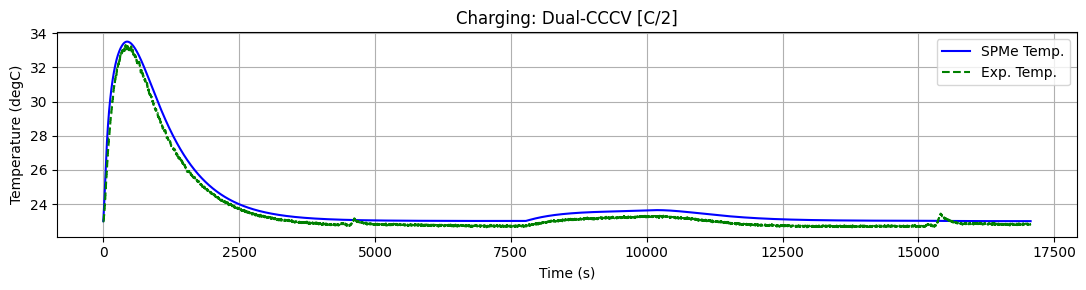

In [15]:
#Define our figure size.
fig = plt.subplots(figsize = (11, 3))

#Plot the two lines we will be comparing, select the desired ones you would like to use.
plt.plot(W10_Ch_1["Time"],  W10_Ch_1["T_SPMe"], "b-", label = "SPMe Temp.")
plt.plot(W10_Ch_1["Time"],  W10_Ch_1["T"], "g--", label = "Exp. Temp.")
#plt.plot(W10_Dch_1["Time"],  W10_Dch_1["V"], "g--", label="Exp. Voltage")
#plt.plot(W8_Ch_1["Time"],  W8_Ch_1["T"], "g-", label="Temperature")
#plt.plot(W8_Ch_1["Time"],  W8_Ch_1["T_SPMe"], "c-", label="Temp. SPMe")
#plt.plot(W8_Ch_1["Time"],  W8_Ch_1["T_Corr"], "r-", label="Temp. Corr.")

#Print out our labels for the x and y axes, along with the title. Display the legend as well.
plt.xlabel("Time (s)")
plt.ylabel("Temperature (degC)")
plt.title("Charging: Dual-CCCV [C/2]")
plt.legend()

#Fix up the formatting, then display the final result.
plt.tight_layout()
plt.grid()
plt.show()

As you can see, we have completed half of the battle with seeing that our simulation works and we can plot these two curves to view how surprisingly smart the PyBAMM model truly is. Now, we can make it even better using neural networks.

## Gathering Data For Our Neural Networks ##
Before we start using our neural networks and defining the architecture, we must first distinguish between X data and Y data.


**X_data:** This is our input data, this will consist of 4 values which include current, average current, average voltage error, and average temperature error.  
**Y_data:** This is our ground-truth data for our outputs, which here will be the voltage error and the temperature error.  
**NOTE:** Since these are columns in our dataframe, we will store these as numpy column stacks.  
**NOTE:** Remember the double brackets around the argument for each column stack.

In [16]:
#Define numpy column stacks for our inputs to our neural networks, and our ground truth values for outputs.
x_data = np.column_stack((W10_Ch_1["I"], W10_Ch_1["Avg_I"], 
                          W10_Ch_1["Avg_V_Error"], W10_Ch_1["Avg_T_Error"]))
y_data = np.column_stack((W10_Ch_1["V_Error"], W10_Ch_1["T_Error"]))


- Now, we need to see how many inputs/samples we have to choose from here. To do this, we take our column stack for x_data and apply a function to that variable.  

**.shape():** Returns a tuple (x,y) where we get the rows and columns. The number of samples will be our row number, or amount of data points which we can choose from. 

- Therefore, we will take the first index of the tuple which represents the rows. As a verification method, taking the length of a .pandas dataframe gives the number of data points as well.

In [17]:
#Obtain the number of samples we have to choose from, then verify the amount matches the before dataframe.
n_samples = x_data.shape[0]
print(len(W10_Ch_1), n_samples)


86998 86998


- As we can see here, we have this many samples which we can use to train our data, as there are this amount of options which we can use for our 4 inputs.  
-  Now, we need to select a ratio for how many points will be used for validation, and how many will be used for actual training.
-  Usually 80% of the data for training and 20% for later validation is a good split.
-  This is a fraction of n_samples, which needs to be parsed as an integer.
-  Based on the splitting process, our validation end here remains the same. You will realize how this works once we do sequential splitting.

**Sequential Splitting:** This involves finally splitting our data up into the validation set and the training set, this can be done using iteration techniques.
- Essentially, we split both our input and output data (x_data and y_data) into groups based on this 80-20 split.
- We iterate through the data points up to the index of the training end (80% of the total number of samples), then iterate from that until the end, which explains why the validation end is the same as the number of samples.  
**NOTE:** Sometimes, we want to include a testing set as well. To do this, we would simply define our validation end to be a bit less than the full amount, and leave the remaining to testing. Essentially, we would have three lines of code in each group instead of 2.

In [28]:
#Define our training endpoint and validation endpoints to resemble the 80-20% split.
train_end = int(n_samples * 0.8)
val_end = n_samples

#Divide both x_data and y_data up into a training set and a validation set.
x_train, y_train = x_data[:train_end], y_data[:train_end]
x_val, y_val = x_data[train_end:val_end], y_data[train_end:val_end]

#Print the shapes to verify that our splitting was successful.
print("Training set:", x_train.shape, y_train.shape)
print("Validation set:", x_val.shape, y_val.shape)


Training set: (69598, 4) (69598, 2)
Validation set: (17400, 4) (17400, 2)


- As you can see, we here define another cool aspect of Python, which is that we can set multiple variables equal to multiple things at once. Here is a good place to utilize that aspect.
- In our tuples, we can see that our thing was successful, with the correct amount of columns and rows for each set.
- The final step to setting up our data involves converting these numpy column stacks into something our torch library can understand.

**PyTorch Tensors:** These are very similar to numpy arrays, except that now we can use encoding to have the operations run on stronger things in our device, such as GPUs.

- To convert to a tensor, we simply use the following function.

**torch.tensor():** Takes two arguments, the first being numpy array we would like to pass and the second being the type of encoding we would like to use.
- The syntax for the encoding argument is as follows: dtype = torch.float32
- We will overwrite the variables which hold the numpy arrays with tensors here.

In [29]:
#Converting our training data into tensors.
x_train = torch.tensor(x_train, dtype = torch.float32)
y_train = torch.tensor(y_train, dtype = torch.float32)

#Creating our validation data into tensors.
x_val = torch.tensor(x_val, dtype = torch.float32)
y_val = torch.tensor(y_val, dtype = torch.float32)

#Let's print an example to view an important point
print(x_val)


tensor([[-0.0539, -0.0546,  0.0402, -0.2921],
        [-0.0541, -0.0546,  0.0402, -0.2921],
        [-0.0542, -0.0546,  0.0402, -0.2921],
        ...,
        [-0.0000, -0.0000,  0.0128, -0.1893],
        [-0.0000, -0.0000,  0.0128, -0.1893],
        [-0.0000, -0.0000,  0.0128, -0.1893]])


- If we look, we can see that if we print our tensors, they still look very similar to our numpy arrays except now they have the word "tensor" tacked onto it.

Now, we will use object-oriented programming to build our architecture for our neural network.

## Building Neural Network Architecture Using Object-Oriented Programming ##
In this section, we are going to learn how to create neural network architecture using object oriented programming. We are going to define two classes, each for a residual neural network. 
We will also utilize torch.nn, which will help us with a lot of the functions and will be written in terms of nn.

**NOTE:** Both of these will have the exact same format, with two methods present.  
**NOTE:** Although similar format, it is good to know the difference between the two.

- When defining the name of our class, this time our class name will be followed by a set of brackets. In here, we will have the parent class for all of our neural network operations in the program.

**nn.Module:** Within the torch.nn import we have, this is the base class for all of our neural network operations. This possesses all of the magic that makes neural networks work, our job is to change the architectural aspects.
- Therefore, the definition of our class will be the name followed by this argument.

Our first function will be what is required for all Python classes, the constructor.

**__init__():** As we know, self is a required argument here as every object created will have the operations (mainly variable initialization) done in this class by being an alias of the self variable. This is the only argument we will use here.

In this constructor function, we first need to call the constructor of the higher-up class called nn.Module as we stated before.

**super():** This is how we call the constructor of our parent class, taking two main arguments which are the name of the class we made, and the self variable to ensure all created objects are a member of that higher-up class as well. We also must say "__init..()" after this to ensure we are calling the correct method.

Now, we will define our layers of neurons which we will use throughout the neural network.  
- In general, these neurons have activation values, with each neuron in further layers depending on every single neuron in the previous layer.
- As an example, a layer with 4 neurons connected to a layer with 2 neurons will have 8 links, meaning 8 selectable weights and potentially 1 bias factor we can play around with when we do weighted sums.
- With our requirements, we want our first layer to have 4 neurons, one for each type of input in x_data, then our final layer to have 2 neurons, one for each type of output in y_data.
- To get layers themselves, we need to utilize a new function of the torch.nn library.

**nn.Linear():** This is the function that allows us to apply a linear transformation to a layer of a neural network to form this weighted sum we hope to apply to each neuron.
- As a result, the two arguments we will use here are the amount of neurons in each layer as integers, the input layer neuron amount then the output layer neuron amount.
- In general, each of these variables represent a connection between layers.
- This applies the following linear transformation: $y = A^{T}x + b$
- Where all values are column vectors, x is the input information (activation or initial amounts), y holds the output activations, b holds our bias for each weighted sum, and A is a (first layer dimension, output layer dimension) matrix with the weights.
**NOTE:** We do not input our bias, this is learned by the torch library and applied by default. If you do not want a bias, you can place a third argument saying "bias = False".  
- Now, we will make these connections between each layer variables each object will have.  
- We will call these "fc_num", where "num" is the connection number.  
**NOTE:** It is very important these are defined in order as the linear combinations are interdependent (The output of one is the input of the next).
- We also need a function to handle these weighted sums and the weights, this is called ReLU.

**Rectified Linear Unit (ReLU):** In general, it is max (0,x) where the argument x is the weighted sum applied to a future-layer neuron.
- This works with the weighted sums because it effectively "shuts off" neurons that are not contributing anything to a future layer.
- This is effective because any negative weighted sums result in 0 activation, and that neuron no longer contributes to the overall thing.
- This makes backpropagation and biases way more effective as other functions like the sigmoid or tanh would only result in a lower activation which could introduce clutter.
- It works as a "survival of the fittest" method for neurons.
- In general, after we have defined our architecture we want every object of this class to have a relu variable. Therefore, we set self.relu equal to simply the ReLU function of the nn library (nn.ReLU()).

Next, we define another function in our class, a "getter" function that actually returns our data.  

**forward():** This getter function in our class is responsible for feeding our data through the neural network architecture we defined in the earlier constructor function. This takes two arguments, obviously the self variable and also some variable x which we pass in ourselves.  
- This is where our idea of thinking of neural network layers as a linear transformation becomes really helpful, because we can now understand really what the nn.linear() function does with two numerical arguments.
- This x data we pass in is a data point with a certain number of values, then this library will express this in terms of a vector which can be manipulated.
- Then, this is linearly transformed to various different dimensions until we arrive at our final dimension, our desired outputs.
- Starting with our first vector as a column vector with our inputs, based on the linear transformation formula we defined earlier, nn.Linear will develop a matrix of weights with the dimensions (layer_1 size, layer_2 size).
- Using dimensional analysis, if we have 4 inputs with a next layer of 12, an input column vector would have the dimensions (4 x 1).
- Since our produced matrix of weights would be (4 x 12), we must transpose this matrix and multiply on the right by the input vector ((12 x 4) x (4 x 1)).
- The input dimension cancels, and we are left with (12 x 1) which is the input vector for the next layer.
- Bias is a vector with the same dimension of the next layer in our transformation (12 x 1), and this is added to the result of the last multiplication we did, one bias for each neuron in the next layer in a column vector.
- Since the neurons are represented as this new vector, any negative values will be screened out by the ReLU function to make them 0, not contributing to transformations anymore.
- As a result, we are going to be overwriting our x variable so the return will be a vector of the same dimension as our desired outputs in y_data.
- Remember that each variable in our constructor represents a connection between layers, so here is the general syntax for all connections besides the last one:

**x = self.relu(self.fc_connection_num(x))**

- Intuitively, we are performing a linear transformation on x, then applying ReLU to that layer to get a new value for x, our next input.
- On the last layer, we simply only apply the linear transformation to x since we do not want ReLU to screen out values here as these are our outputs.
- In a sense, the "fc" variables in our constructor class are functions of the nn.Module class with specific instructions on how to transform based on our numerical inputs.
- Finally, we are going to define one more class.

**ResidualNN_Aging():** This is the class we will use for our aged datasets which are present later in our pkl files, this possesses the exact same format as the previous.

Below, we can see the application of this information to our program in these two classes.  
**NOTE:** The values for our linear transformations are mostly trial and error, but here we will use some sample values.  
**NOTE:** When we used aged data sets, we may use different inputs. For the rest of the program, we will focus on our first class.


 


In [30]:
class ResidualNN(nn.Module):
    ''' Our class to act as our residual neural network, with a constructor function to access nn.module,
    and then a getter function to pass through the data points through our defined architecture.'''
    
    #Define our constructor function for this class.
    def __init__(self):
        #Ensure all instances of "self" are constructed in the nn.module class as well.
        super(ResidualNN, self).__init__()
        #Define layer sizes for our neural network architecture.
        self.fc1 = nn.Linear(4,32)
        self.fc2 = nn.Linear(32,16)
        self.fc3 = nn.Linear(16,16)
        self.fc4 = nn.Linear(16,2)
        #Define our relu variable as the function from the upper class.
        self.relu = nn.ReLU()
        
    #Define our getter function to obtain the neural network's response to our inputted data.
    def forward(self, x):
        #Pass our x value through the layers of the neural network, ensuring to overwrite the variable each time.
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        #Return our newly dimensioned x data point back to the main program.
        return x

class ResidualNN_Aging(nn.Module):
    ''' Our class to act as our residual neural network for aging cells, with a constructor function to access nn.module,
    and then a getter function to pass through the data points through our defined architecture.'''
    
    #Define our constructor function for this class.
    def __init__(self):
        #Ensure all instances of "self" are constructed in the nn.module class as well.
        super(ResidualNN, self).__init__()
        #Define layer sizes for our neural network architecture.
        self.fc1 = nn.Linear(3,8)
        self.fc2 = nn.Linear(8,8)
        self.fc3 = nn.Linear(8,1)
        #Define our relu variable as the function from the upper class.
        self.relu = nn.ReLU()
        
    #Define our getter function to obtain the neural network's response to our inputted data.
    def forward(self, x):
        #Pass our x value through the layers of the neural network, ensuring to overwrite the variable each time.
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        #Return our newly dimensioned x data point back to the main program.
        return x

## Running Our Data Through Our Neural Network & Calculating/Observing Losses ##

Now, we will return to our main program and define the required variables before we jump into training this neural network. Here are some good terms to know:

**Loss Functions:** This is how we tell the machine to learn, by comparing the answers it outputs with those ground truth values we defined as y_data. 
- This cost/loss function is a function dependent on all of the chosen weights, where we then find minimums to lower this cost to the lowest part.
- In this case, we will use the Mean Squared Error (MSE) which is our root mean squared error without the squareroot with the differences being between transformed x_data neurons and y_data ground truth values.
- In Python, we use another function of the nn library simply called MSELoss. We will set the open call of this function equal to a variable called "criterion" as seen below.

**Optimizers:** This is what is responsible in our program for updating the weights in our neural network, this is done through a process called optimization.
- In terms how this is done, there are many different ways and this is one of the aspects which differentiates different models from each other.
- In general, this is how we utilize the cost function to inspect the weights which are causing problems. It helps us out with gradient descent, which is described below.
- Here, we are using a powerful PyTorch optimizing algorithm, which is described below along with what it is derived from.


**Gradient Descent:** This is how we find the optimal weights and biases from the cost functions, using the gradient of this cost function with many dependents to consistently use the highest rates of change as a roadmap to minima.  
**Stochastic Gradient Descent (SGD):** Deals with the issue of cost as calculating the gradient descent has a huge amount of memory needed. Instead, we now use a random (stochastic) sample point as opposed to the entire training dataset. This is computationally efficient.  
**Learning Rate:** A very important aspect for gradient descent this indicates how much we move along our function towards our minima, or the amount of weights we update on each iteration.  
- It is important to realize that a learning rate to high requires too many updates and can lead to overfitting, but a low rate may not learn enough and this causes underfitting.
- All of this is a matter of how fast can we converge to a minimum in our function. For example, a low learning rate may get stuck in local minima, and a high learning rate may overshoot.
- For this program, we will use 0.01 as the default as it is not too high, or too low.

**Adam:** A good optimizer for our data as it has many good features. This combines many techniques that make this memory efficient and faster than traditional gradient descent. This combines two methods of gradient descent, SGD with momentum and RMSProp.  
**SGD With Momentum:** SGD stands for stochastic gradient descent, and the momentum refers to the usage of moving averages to help out with memory.  
**RMSProp:** This is how we propagate backward in our neural networks, but this time with an efficient way involving adaptive learning rates for each parameter (weight/bias) in our set.

- To call one of these optimizers, we call nn's optim library, with the optimizer name as the function. In our program, this function will contain two arguments.
- The first is the parameters of our model which we can access by attaching .parameters() to the end of the name.
- The second argument is our set learning rate, which we can write as "lr = amount".  
**NOTE:** Ensure to store this as a variable called optimizer as we will access functions of this.
- Next, we will create an integer variable for epochs, which is the amount of times we will cycle through this process of training our neural networks.
- We also here will create two empty lists for numerical values for our losses in both our training and validation phase.
  


In [31]:
#Use a variable to store our class as a variable which we will be able to access using various functions.
model_residual = ResidualNN()

#Define which loss function we will be working with for our neural network model.
criterion = nn.MSELoss()

#Select our optimizer for this model, here will be using the Adam model with a default learning rate of 0.01.
optimizer = optim.Adam(model_residual.parameters(), lr = 0.01)

#Define our number of epochs, along with lists for our training losses.
epochs = 1000
train_losses = []
val_losses = []

Now, that "epochs" variable is going to be responsible for running our big for loop that returns to us the information we require. This takes many steps, we will outline each one here, everything that goes inside the for loop will repeated for the number of epochs. Each step is outlined below.

**Functions to Know:**

**.train():** Attached to the end of model-holding variables to put it in training mode.  
**.zero_grad():** Used on optimizer variables initially to set our gradients to zero.  
**.backward():** Used on loss scalars (1D tensors) to then back propagate through the neural network, performing chain rule partial derivative calculations on our weighted sums and relu functions to find dependence on each neuron.  
**.step():** Applied to optimizer variables after .backward() has been performed to now update the weights accordingly.  

1. Place our model in training mode. This can be done by taking the variable that contains our model class and applying the .train() function to it.
2. Set all of our gradients equal to zero initially before we train our model. This can be done by applying the zero_grad() function to the optimizer variable.

**NOTE:** These "optimizer" and "model_residual" variables are mutable things in python, so there is no need to overwrite the variable. Simply apply the function to each one.

3. Run the data through the neural network. To do this, we will store our extracted data as a variable called "y_pred_train". These are the values for our y data which our neural network predicts based off our inputted x_data. We use the model_residual variable again and pass into this class our x_train data.
4. Obtain our loss from the training data, using our criterion variable with two arguments. The first is the data holding our neural-network-predicted values, and the second is our actual y_data holding our ground truth values. We store this as train_loss.
5. Compute our gradients with repsect to our current parameters. This is done by applying the .backward() function to our train_loss variable, due to mutability no overwriting is needed.
6. Now, we want to analyze these gradients, and to do this we go back to our optimizer variable and apply the .step() function. This will update the parameters for us based on the optimizer we chose.
7. Switch to validation mode. This can be done by applying the .eval() function to our model variable.
8. Turn off gradient analysis mode on torch. This can be done using the "with" keyword, with our conditional statement after saying "torch.no_grad():
9. Obtain our predicted values for feeding in our x_validation data into the neural network the same way as before.
10. Use our criterion to evaluate the loss on our y validation and y predicted sets the same way as before.
11. Now, since our training loss and validation losses are both numbers, we can use the .item() function to convert this from a tensor to a Python float and append our empty lists with the losses on each epoch. We should see these decreasing.
12. Print out each of our losses on a particular rate using modulus division to ensure our model is working.

**NOTE:** We can only use the .item() function on scalars, which are tensors with only one numerical value. We do this with loss amounts since they sum all of the differences into one value which we can then use in python.


In [32]:
#A for loop which we control with the amount of epochs (iterations).
for epoch in range(epochs):
    #Start the training phase by putting our model in train mode and zeroing out our gradients.
    model_residual.train()
    optimizer.zero_grad()

    #Feed our data through the model to obtain our loss for the current epoch.
    y_pred_train = model_residual(x_train)
    train_loss = criterion(y_pred_train, y_train)

    #Backpropagate through the neural network and update our parameters accordingly.
    train_loss.backward()
    optimizer.step()

    #Now, start the validation phase by setting our model to validation/evaluation mode.
    model_residual.eval()

    #Obtain the loss for our validation set to verify the performance of the updated parameters. Ensure gradients are not involved.
    with torch.no_grad():
        y_pred_val = model_residual(x_val)
        val_loss = criterion(y_pred_val, y_val)

    #Append our empty lists with the losses to monitor the performance of the neural network.
    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())

    #For every 100 epochs, print the error to ensure the error is decreasing. Also print the final epoch, and the tensors throughout to see the changes.
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Train Loss: {train_loss.item():.4f}, Val Loss: {val_loss.item():.4f}")
        print(f" Predicted Tensor: {y_pred_train}, Cost: {train_loss}\n")
    #On the final epoch, print the tensor length to see how it has the same size as the amount of data points in our y and x data.
    elif epoch == (epochs - 1):
        print(f"Final Epoch: Train Loss: {train_loss.item():.4f}, Val Loss: {val_loss.item():.4f}")
        print(f" Predicted Tensor: {y_pred_train}, Tensor Length: {len(y_pred_train)} Cost: {train_loss}")

Epoch 0: Train Loss: 0.2978, Val Loss: 0.1327
 Predicted Tensor: tensor([[-1.5824,  0.3216],
        [-1.5987,  0.3258],
        [-1.6087,  0.3250],
        ...,
        [-0.0026,  0.2469],
        [-0.0026,  0.2469],
        [-0.0026,  0.2469]], grad_fn=<AddmmBackward0>), Cost: 0.2978362739086151

Epoch 100: Train Loss: 0.0034, Val Loss: 0.0037
 Predicted Tensor: tensor([[ 0.1195, -0.3890],
        [ 0.1201, -0.3899],
        [ 0.1202, -0.3937],
        ...,
        [ 0.0438, -0.2348],
        [ 0.0438, -0.2348],
        [ 0.0438, -0.2348]], grad_fn=<AddmmBackward0>), Cost: 0.003364949719980359

Epoch 200: Train Loss: 0.0013, Val Loss: 0.0017
 Predicted Tensor: tensor([[ 0.1029, -0.2778],
        [ 0.1045, -0.2680],
        [ 0.1042, -0.2846],
        ...,
        [ 0.0433, -0.2823],
        [ 0.0433, -0.2823],
        [ 0.0433, -0.2823]], grad_fn=<AddmmBackward0>), Cost: 0.0013162771938368678

Epoch 300: Train Loss: 0.0011, Val Loss: 0.0016
 Predicted Tensor: tensor([[ 0.1015, -0.345

- As we can see, each epoch we feed in our training data and validation data, the tensor continues to update itself

Now, we will do our 2nd plot of the program, which involves plotting our training losses and our validation losses to see the general decrease down to a near zero amount. This will be done using the same functions as before. This brings up some good points.  
- The plt.plot() function can also only have three arguments, one common thing between both ways is that the last two arguments are the colour code and the label as a string which will be used in the legend.
- If we let the first argument simply be a list, this is only used when we only want to graph numerical data points with their corresponding value as the y-axis. Here, we will do this twice for each type of loss.
- In this case, the x-label will be the epochs and the y-label will be the loss amount.

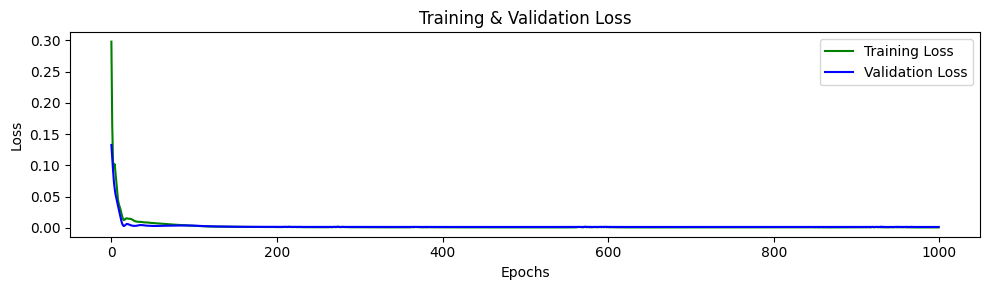

In [33]:
#Create our plot for both of our losses in the same way we did before.
fig = plt.subplots(figsize = (10,3))
plt.plot(train_losses, "g-", label = "Training Loss")
plt.plot(val_losses, "b-", label = "Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Validation Loss")
plt.tight_layout()
plt.show()

This is a great way to see the magic of machine learning, seeing how low the errors can go and how they converge to such low values. Now, we will apply this to our old data in order to correct those simulation values which we obtained from our PyBAMM simulation.

## Using Our Neural Network To Correct PyBAMM-Generated Values ##
Now, we will evaluate on the testing set, which in this case is feeding all of our data into our neural network at once with no sequential splitting.
- To begin, we need to now define our final set of data, which is the test set.

**Test Set:** This is the set we use on our fully trained neural network to see if it works out. Sometimes, we use a fraction of our original sequential split but this time, we have many different charging profiles. Therefore, we can just use another dataframe we have loaded.
- Now, we are going to preform the exact same process as before with no gradients to simply see how good our model is. Here is a process to serve as a quick recap.

1. Create column stacks for our x and y data using the same column information.
2. No sequential splitting is needed, simply convert these column stacks to tensors.
3. Place the model in evaluation mode, then set the torch library to no-gradient mode.
4. Run the test set through the neural network and calculate the cost.

After this is finished, we will have our final loss amount from the test.


In [34]:
#Evaluate the test set using another loaded charging profile. First, create the same column stacks again.
x_test = np.column_stack((W5_Ch_1["I"], W5_Ch_1["Avg_I"], 
                          W5_Ch_1["Avg_V_Error"], W5_Ch_1["Avg_T_Error"]))
y_test = np.column_stack((W5_Ch_1["V_Error"], W5_Ch_1["T_Error"]))

#Convert our testing data into tensors like we did before, no sequential splitting needed.
x_test = torch.tensor(x_test, dtype = torch.float32)
y_test = torch.tensor(y_test, dtype = torch.float32)

#Set our model into the proper state for evaluating data, no gradients and evaluation mode.
model_residual.eval()
with torch.no_grad():
    #Feed our data through the neural network and calculate the final cost.
    y_pred_test = model_residual(x_test)
    test_loss = criterion(y_pred_test, y_test)

#Verify that our final loss is adequate.
print(f"Final Test Loss: {test_loss.item():.4f}")
    

Final Test Loss: 0.0898


Now, we will create these new, corrected values to our simulation and add them to our dataframes. This is relatively simple, all we need to do is extract values from what we recieved after we ran our test set through the neural network.

1. Create two new columns known as "V_Error_Pred" and "T_Error_Pred.
2. Create two more columns with our corrected values, by adding our newly-created error columns to our SPMe simulation columns with values for terminal voltage and temperature.  
**NOTE:** We can either add or subtract this error, depending on if the simulation overshoots or undershoots our ground-truth values.
3. Finally, we will calculate the rmse for voltage and temperature. We can either store this as a column or constant values. Here, we will store them as columns for continuity.

**Converting Tensors to Numpy Arrays:** In this case, the predicted values we recieve from calling our model are returned in the form of a 2D tensor, with each column being the voltage and temperature error. This tensor has as many rows as we give it based on the sequential splitting, and is constantly updated every epoch in which we pass data through. 
- In order to extract the columns, we will use the colon operator to iterate through the rows.
- Then, we will apply the .numpy() function to this aspect to convert this to a numpy column.
- These will be called our predicted errors for voltage and temperature, the general syntax is as follows:

**Cell_Name["V or T_Error_Pred"] = y_pred_test[:,0 or 1].numpy()**

- Then, we add these predicted errors to the simulated values for voltage and temperature to correct our values. We do as we've done before, these columns are named as our corrected values.
- Then we calculate our final RMSE between our corrected values and our actual voltage and temperature values the same way we did before in previous sections of our program.
- We will also print these to verify a sufficient and low amount.

**NOTE:** Use single quotes in the column names when working with f-strings.

In [35]:
#Iterate through our final tensors to create our final numpy columns for our predicted voltage and temperature errors.
W5_Ch_1["V_Error_Pred"] = y_pred_test[:,0].numpy()
W5_Ch_1["T_Error_Pred"] = y_pred_test[:,1].numpy()

#Create our corrected values based on how the model learned our data, we can then see the improvement.
W5_Ch_1["V_Corr"] = W5_Ch_1["V_SPMe"] + W5_Ch_1["V_Error_Pred"]
W5_Ch_1["T_Corr"] = W5_Ch_1["T_SPMe"] + W5_Ch_1["T_Error_Pred"]

#Create columns for our final RMSE for each of the variables.
W5_Ch_1["V_Final_RMSE"] = np.sqrt(np.mean((W5_Ch_1["V"] - W5_Ch_1["V_Corr"])**2))
W5_Ch_1["T_Final_RMSE"] = np.sqrt(np.mean((W5_Ch_1["T"] - W5_Ch_1["T_Corr"])**2))

print(f"Final Voltage RMSE: {W5_Ch_1['V_Final_RMSE'].values[0]}\nFinal Temperature RMSE: {W5_Ch_1['T_Final_RMSE'].values[0]}")

Final Voltage RMSE: 0.013319694480760617
Final Temperature RMSE: 0.4235624044548501


To close off the main part of our program, lets plot these final values on two graphs to really see the effect machine learning has on the simulation.

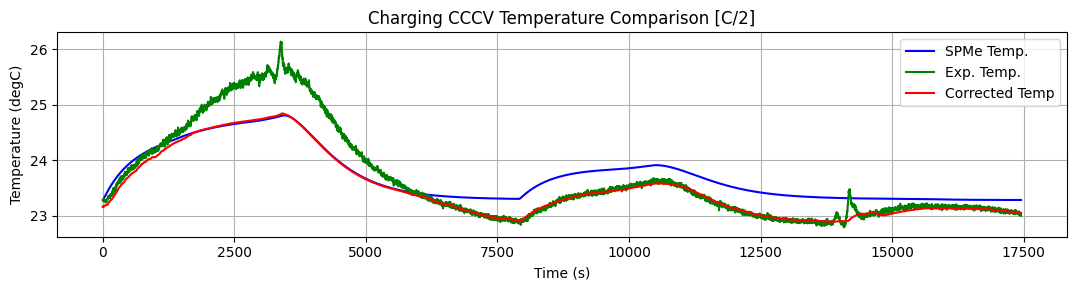

In [36]:
#Define our figure size for our final plot.
fig = plt.subplots(figsize = (11, 3))

#Plot the three lines we will be comparing, which involve ground truth, experimental, and corrected values which help to improve our simulation.
plt.plot(W5_Ch_1["Time"],  W5_Ch_1["T_SPMe"], "b-", label = "SPMe Temp.")
plt.plot(W5_Ch_1["Time"],  W5_Ch_1["T"], "g-", label = "Exp. Temp.")
plt.plot(W5_Ch_1["Time"],  W5_Ch_1["T_Corr"], "r-", label = "Corrected Temp")

#Print out our labels for the x and y axes, along with the title. Display the legend as well.
plt.xlabel("Time (s)")
plt.ylabel("Temperature (degC)")
plt.title("Charging CCCV Temperature Comparison [C/2]")
plt.legend()

#Fix up the formatting, then display the final result.
plt.tight_layout()
plt.grid()
plt.show()

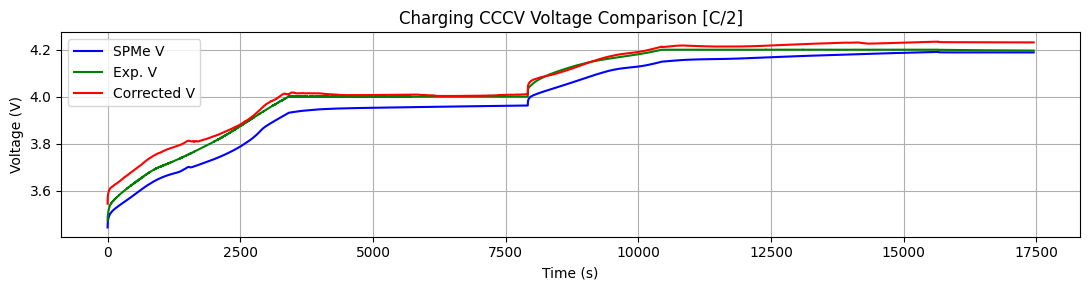

In [27]:
#Define our figure size for our final plot.
fig = plt.subplots(figsize = (11, 3))

#Plot the three lines we will be comparing, which involve ground truth, experimental, and corrected values which help to improve our simulation.
plt.plot(W5_Ch_1["Time"],  W5_Ch_1["V_SPMe"], "b-", label = "SPMe V")
plt.plot(W5_Ch_1["Time"],  W5_Ch_1["V"], "g-", label = "Exp. V")
plt.plot(W5_Ch_1["Time"],  W5_Ch_1["V_Corr"], "r-", label = "Corrected V")

#Print out our labels for the x and y axes, along with the title. Display the legend as well.
plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
plt.title("Charging CCCV Voltage Comparison [C/2]")
plt.legend()

#Fix up the formatting, then display the final result.
plt.tight_layout()
plt.grid()
plt.show()

- As we can see, these corrected values further analyze the relationship between the experimental (ground-truth) and PyBAMM generated values, doing a good job of eliminating noise and smoothing out the graphs.
- These residual neural networks are essential for extracting data out of input data, obtaining insight into the complex relationships that may present.